# COSI 107 Report Demonstration

## Author: Michelangelo Zampieri 

This notebook contains the code for the demonstration section in my report for COSI 107 Intro to Computer Security. 

Here I load the CNN created earlier and execute the second attack. 

import needed libraries

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import foolbox as fb 

Load the model

In [32]:
model_path = './models/mnist_cnn.pth'
if os.path.exists(model_path):
    model = torch.load(model_path)
else:
    raise FileNotFoundError(f"Model file {model_path} not found.")

Redefine architecture

In [33]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [34]:
# Load model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("./models/mnist_cnn.pth", map_location=device))
model.eval()
print("Model loaded successfully")

Model loaded successfully


Get the data ready

In [35]:
test_transform = transforms.ToTensor()

test_dataset = datasets.MNIST(root="./data", train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

Wrap the model in the foolbox 

In [36]:
fmodel = fb.PyTorchModel(
    model,
    bounds=(0, 1),
    preprocessing={"mean": 0.1307, "std": 0.3081},  # MNIST normalization
)

Initiate counts

In [37]:
total = 0
adv_correct = 0
clean_correct = 0

Prepare the PGD attack

In [38]:
# PGD attack                      
attack = fb.attacks.PGD()
eps = 0.15

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # Clean predictions
    with torch.no_grad():
        clean_preds = model(images).argmax(dim=1)
        clean_correct += (clean_preds == labels).sum().item()

    # Adversarial attack
    raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=eps)

    with torch.no_grad():
        adv_preds = model(clipped).argmax(dim=1)
        adv_correct += (adv_preds == labels).sum().item()

    total += labels.size(0)

# Accuracy results
print(f"Clean Accuracy:       {clean_correct / total:.2%} ({clean_correct}/{total})")
print(f"Adversarial Accuracy: {adv_correct / total:.2%} ({adv_correct}/{total})")

Clean Accuracy:       98.79% (9879/10000)
Adversarial Accuracy: 42.38% (4238/10000)


Make predictions

In [ ]:
with torch.no_grad():
    adv_preds = model(clipped).argmax(dim=1)
    adv_correct = (adv_preds == labels).sum().item()
    total = labels.size(0)
    print(f"Adversarial Accuracy: {adv_correct / total:.2%} ({adv_correct}/{total})")

Adversarial Accuracy: 42.00% (42/100)


Function to plot predictions

In [ ]:
def plot_images(images, labels, predictions=None):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        if predictions is not None:
            title = f"True: {labels[i]}, Pred: {predictions[i]}"
        else:
            title = f"Label: {labels[i]}"
        ax.set_title(title)
        ax.axis('off')
    plt.show()

Plot the images

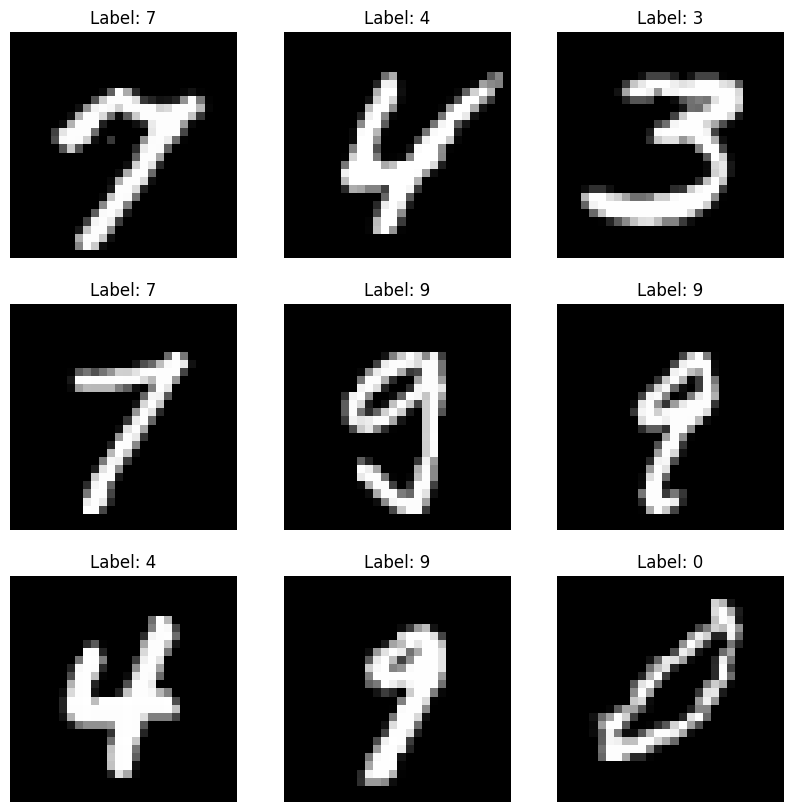

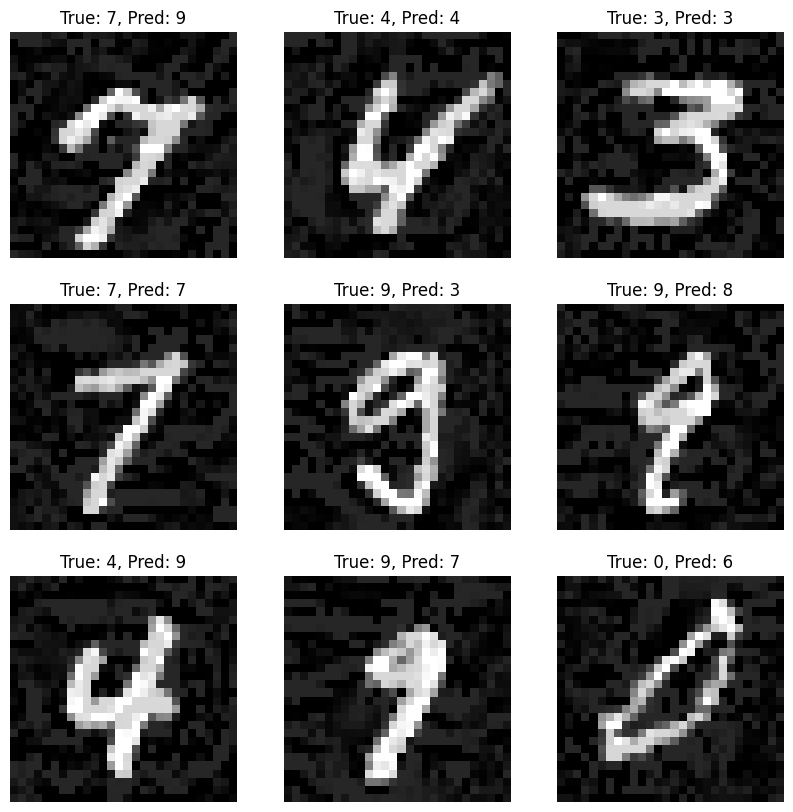

In [41]:
# Plot clean images
plot_images(images.cpu(), labels.cpu())
# Plot adversarial images
plot_images(clipped.cpu(), labels.cpu(), adv_preds.cpu())

Create a confusion matrix

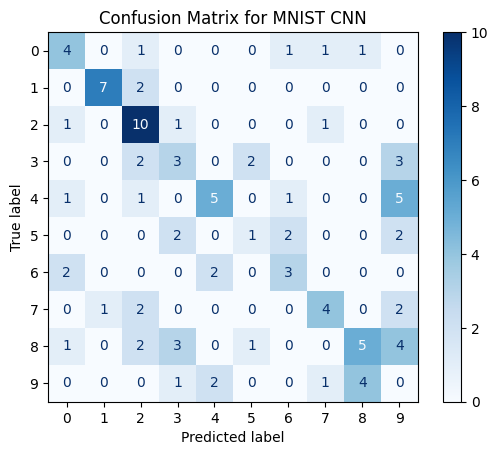

In [42]:
# Confusion matrix
cm = confusion_matrix(labels.cpu(), adv_preds.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MNIST CNN")
plt.show()

Function to plot the adv examples

In [43]:
def plot_adversarial_examples(images, adv_images, labels, predictions, adv_predictions, is_adv, num_show=10):
    images = images.cpu().detach()
    adv_images = adv_images.cpu().detach()
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()
    adv_predictions = adv_predictions.cpu().numpy()
    is_adv = is_adv.cpu().numpy()

    plt.figure(figsize=(12, 4 * num_show))
    for i in range(num_show):
        # Original image
        plt.subplot(num_show, 2, 2 * i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Original\nTrue: {labels[i]} | Pred: {predictions[i]}")
        plt.axis('off')

        # Adversarial image
        plt.subplot(num_show, 2, 2 * i + 2)
        plt.imshow(adv_images[i][0], cmap='gray')
        plt.title(f"Adversarial\nAdv Pred: {adv_predictions[i]} | Fooled: {is_adv[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Make the predictions and plotting them

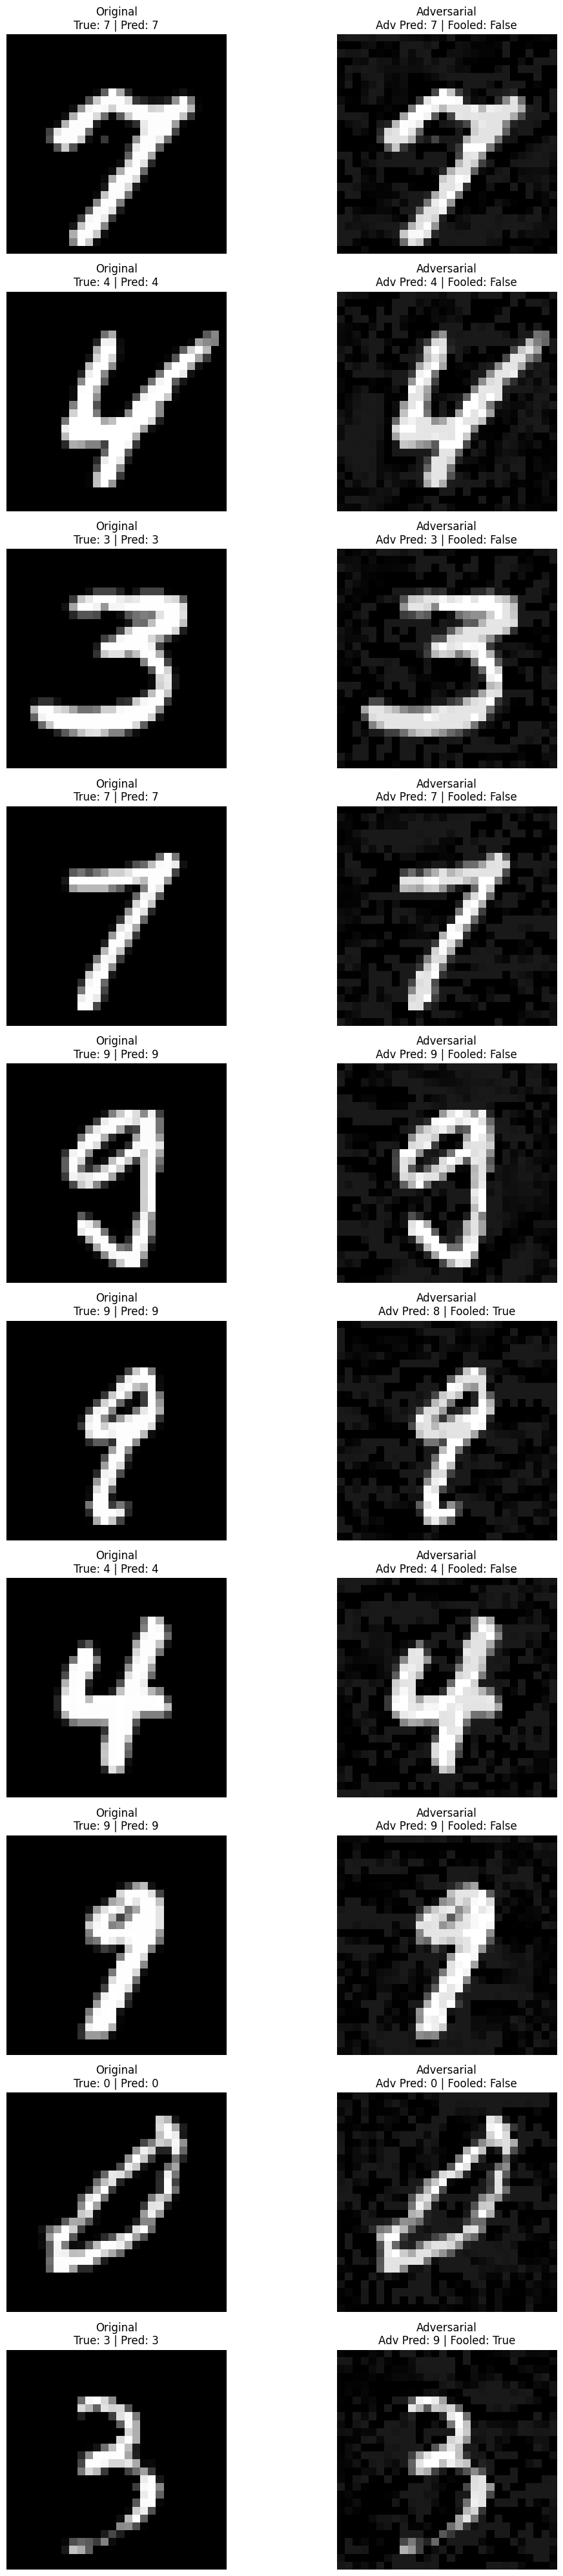

In [44]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.1)

# Get predictions
with torch.no_grad():
    orig_preds = model(images).argmax(dim=1)
    adv_preds = model(clipped).argmax(dim=1)

# Plot results
plot_adversarial_examples(images, clipped, labels, orig_preds, adv_preds, is_adv)

Show images side by side

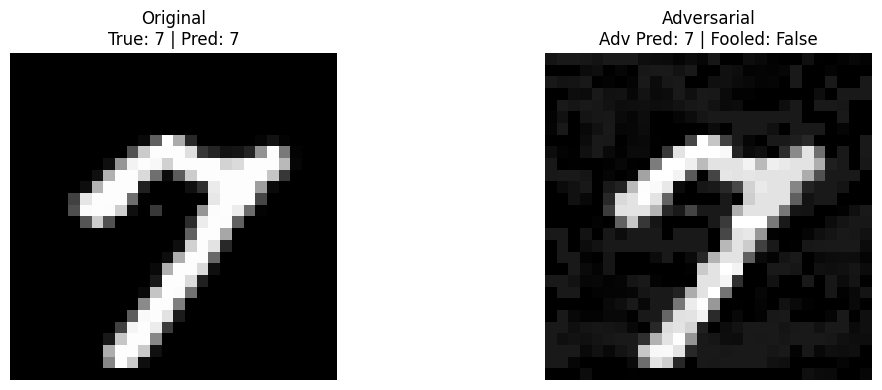

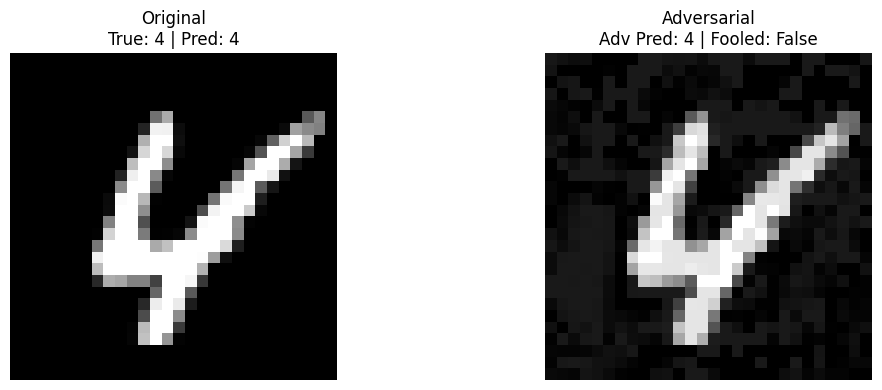

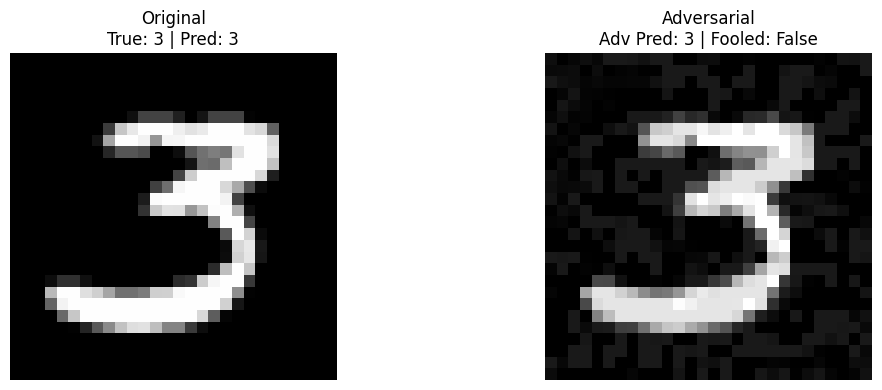

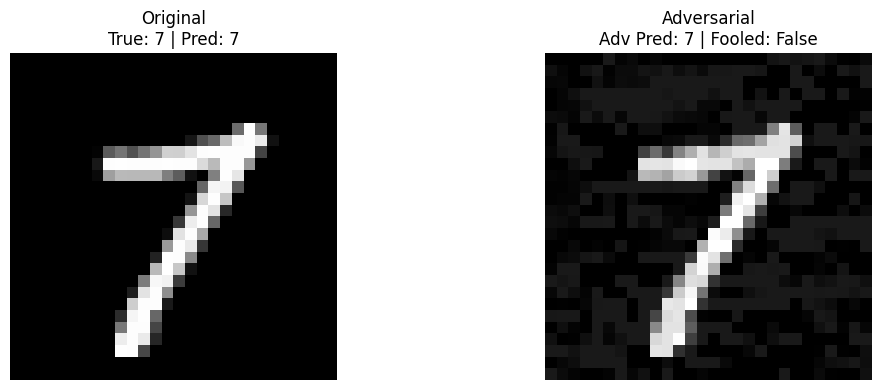

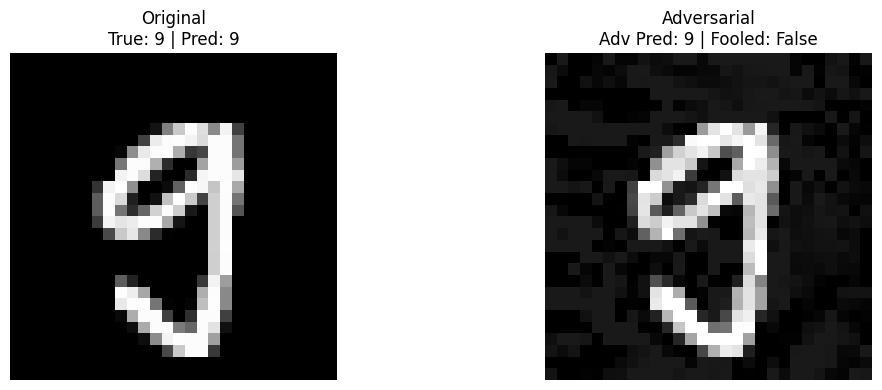

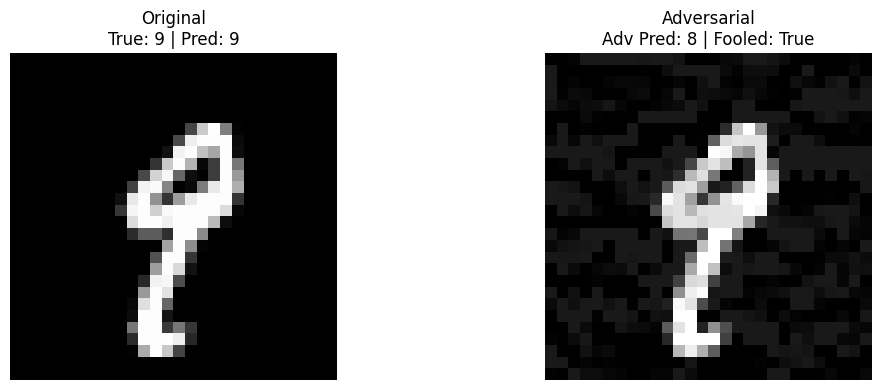

In [45]:
# Show an example of a fooled image
def show_example(images, adv_images, labels, predictions, adv_predictions, is_adv, index):
    images = images.cpu().detach()
    adv_images = adv_images.cpu().detach()
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()
    adv_predictions = adv_predictions.cpu().numpy()
    is_adv = is_adv.cpu().numpy()

    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(images[index][0], cmap='gray')
    plt.title(f"Original\nTrue: {labels[index]} | Pred: {predictions[index]}")
    plt.axis('off')

    # Adversarial image
    plt.subplot(1, 2, 2)
    plt.imshow(adv_images[index][0], cmap='gray')
    plt.title(f"Adversarial\nAdv Pred: {adv_predictions[index]} | Fooled: {is_adv[index]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# Show an example of a fooled image

for i in range(len(is_adv)):
    show_example(images, clipped, labels, orig_preds, adv_preds, is_adv, i)
    if (is_adv[i] == 1):
        break